In [1]:
from obspy.signal.trigger import classic_sta_lta

from obspy.taup import TauPyModel
from matplotlib import pyplot as plt, patches
import obspy
import numpy as np

In [7]:
provider = "IRIS" 
year = 2018
evt_check = "20181128101709090000"
data_sac = f'/media/tianjue/Data/SEAsia/Auto_PickP/Use/Download/{provider}/SAC/{year}'
data_dir = f'{data_sac}/{evt_check}'

1 Trace(s) in Stream:
II.KURK.00.BHZ | 2018-11-28T10:17:09.119538Z - 2018-11-28T11:17:09.069538Z | 20.0 Hz, 72000 samples


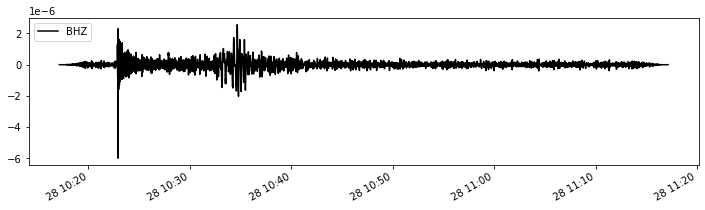

In [8]:
### prepare the seismic data
net = "II"
sta = "KURK"
loc = "00"
channel = "BHZ"
st = obspy.read(f"{data_dir}/{net}.{sta}.{loc}.{channel}.SAC.bp")
print(st)

### visualize the seismic data
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot()
ax.plot(st[0].times("matplotlib"), st[0].data, color="black", label=st[0].stats.channel)
ax.xaxis_date()
ax.legend(loc ="upper left")

fig.autofmt_xdate()
plt.show()

In [9]:
model = TauPyModel(model="iasp91")

gcarc = st[0].stats.sac.gcarc
evdp = st[0].stats.sac.evdp

arrivals = model.get_travel_times(source_depth_in_km=evdp,
                        distance_in_degree=gcarc, phase_list=["ttp"])

tp_iasp91 = arrivals[0].time
print("Tp = {:.2f}s".format(tp_iasp91))

Tp = 342.27s


In [10]:
### predict P-wave arrival using STA/LTA method
df = st[0].stats.delta
cft = classic_sta_lta(st[0].data, int(0.5/df), int(60/df))   # 0.5s short-term window; 3.0s long-term window

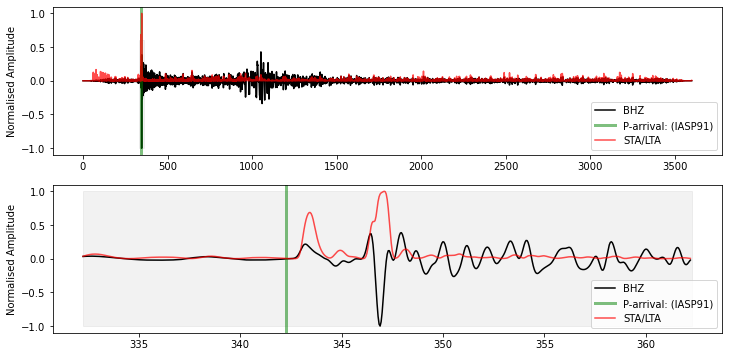

In [11]:
### visualize the prediction result
wlength = st[0].stats.sac.npts

for s in range(0, int(st[0].stats.endtime - st[0].stats.starttime), wlength):
    t0 = st[0].stats.starttime + s
    t1 = t0 + wlength
    subst = st.slice(t0, t1)

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(211)
ax1.plot(subst[-1].times(), subst[-1].data / np.amax(abs(subst[-1].data)), 'k', label=subst[-1].stats.channel)
ax1.axvline(x=tp_iasp91,color="green",linewidth=3,alpha=0.5,label="P-arrival: (IASP91)")
ax1.set_ylabel('Normalised Amplitude')
ax1.plot(subst[-1].times(), cft / np.amax(cft), label="STA/LTA", color="red",alpha=0.7)
rect = patches.Rectangle((tp_iasp91-10, -1), 30, 1.6*1.0, color='gray',alpha=0.1)
ax1.add_patch(rect)
ax1.legend(loc="lower right")

ax2 = fig.add_subplot(212)
idxs1 = int((tp_iasp91-10)/st[0].stats.delta)
idxs2 = int((tp_iasp91+20)/st[0].stats.delta)
ax2.plot(subst[-1].times()[idxs1:idxs2], subst[-1].data[idxs1:idxs2] / np.amax(abs(subst[-1].data[idxs1:idxs2])), 'k', label=subst[-1].stats.channel)
ax2.axvline(x=tp_iasp91,color="green",linewidth=3,alpha=0.5,label="P-arrival: (IASP91)")
ax2.set_ylabel('Normalised Amplitude')
ax2.plot(subst[-1].times()[idxs1:idxs2], cft[idxs1:idxs2] / np.amax(cft[idxs1:idxs2]), label="STA/LTA", color="red",alpha=0.7)
rect = patches.Rectangle((tp_iasp91-10, -1), 30, 2.0*1.0, color='gray',alpha=0.1)
ax2.add_patch(rect)
ax2.legend(loc="lower right")

plt.show()